In [ ]:
# Mount google drive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Prepping kaggle cli
# Make sure to upload kaggle.json first before running

# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list -s retinal

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/retinal-disease-classification                      Retinal Disease Classification                        7GB  2021-08-16 10:23:33           2586         86  0.875            
paultimothymooney/kermany2018                                 Retinal OCT Images (optical coherence tomography)    11GB  2018-03-25 15:04:56          18473        435  0.75             
sshikamaru/glaucoma-detection                                 Glaucoma Detection                                  402MB  2022-07-13 15:10:46           4904        123  0.8235294        
gunavenkatdoddi/eye-diseases-classification                   eye_dise

In [ ]:
# Download dataset to drive

# !kaggle datasets download 'andrewmvd/retinal-disease-classification' -p '/content/gdrive/MyDrive/retinaldata/'

100% 7.41G/7.43G [01:22<00:00, 146MB/s]
100% 7.43G/7.43G [01:24<00:00, 94.5MB/s]


In [ ]:
# Uncompress dataset to working directory

!unzip /content/gdrive/MyDrive/retinaldata/retinal-disease-classification.zip

Archive:  /content/gdrive/MyDrive/retinaldata/retinal-disease-classification.zip
  inflating: Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv  
  inflating: Evaluation_Set/Evaluation_Set/Validation/1.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/10.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/100.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/101.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/102.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/103.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/104.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/105.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/106.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/107.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/108.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/109.png  
  inflating: Evaluation_Set/Evaluation_Set/Validation/11.png  
  inflating: Evalu

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 as cv
import pickle

import time

import gc
from tensorflow.keras import layers, models, backend as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, Callback

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def undersample(df, label):
    classes = df[label].value_counts().to_dict()
    least = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[label] == key])
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least))
    final_df = pd.concat([pd.concat(classes_sample),classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

def oversample(df, label):
    classes = df[label].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[label] == key])
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    final_df = pd.concat([pd.concat(classes_sample),classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [ ]:
# Data preparation

# Paths
path_train_labels = '/content/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
path_valid_labels = '/content/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
path_test_labels = '/content/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'
path_train_data = '/content/Training_Set/Training_Set/Training/'
path_valid_data = '/content/Evaluation_Set/Evaluation_Set/Validation/'
path_test_data = '/content/Test_Set/Test_Set/Test/'


# Dataset size
train_size = 1920
valid_size = 640
test_size = 640
subset = 1  # Set to 1 to use full dataset
train_size, valid_size, test_size = int(train_size * subset), int(valid_size * subset), int(test_size * subset)

# Feature and Label
feat = 'img_path'
labels = ['No_Disease', 'Disease_Risk']

# Image dimensions
resizeX = 150
resizeY = 150

train_df = pd.read_csv(path_train_labels)
valid_df = pd.read_csv(path_valid_labels)
test_df = pd.read_csv(path_test_labels)

train_df[feat] = [path_train_data + f'{id}.png' for id in train_df['ID']]
valid_df[feat] = [path_valid_data + f'{id}.png' for id in valid_df['ID']]
test_df[feat] = [path_test_data + f'{id}.png' for id in test_df['ID']]

train_df[labels[0]] = np.logical_xor(train_df[labels[1]], 1).astype(int)
valid_df[labels[0]] = np.logical_xor(valid_df[labels[1]], 1).astype(int)
test_df[labels[0]] = np.logical_xor(test_df[labels[1]], 1).astype(int)

train_df = train_df[[feat, *labels]]
valid_df = valid_df[[feat, *labels]]
test_df = test_df[[feat, *labels]]

# train_df = oversample(train_df, labels[1])
# valid_df = oversample(valid_df, labels[1])
# train_df = undersample(train_df, labels[1])
# valid_df = undersample(valid_df, labels[1])

train_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valid_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = train_imgen.flow_from_dataframe(train_df[:train_size],
                                              x_col=feat,
                                              y_col=labels,
                                              target_size=(resizeX, resizeY),
                                              class_mode='raw',
                                              shuffle=True)

valid_gen = valid_imgen.flow_from_dataframe(valid_df[:valid_size],
                                          x_col=feat,
                                          y_col=labels,
                                          target_size=(resizeX, resizeY),
                                          class_mode='raw',
                                          shuffle=True)

test_gen = test_imgen.flow_from_dataframe(test_df[:test_size],
                                            x_col=feat,
                                            y_col=labels,
                                            target_size=(resizeX, resizeY),
                                            class_mode='raw',
                                            shuffle=False)

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


In [ ]:
start = time.time()

# Create arrays using image generators for K-Fold Cross Validation
X_train, X_valid, y_train, y_valid = ([] for i in range(4))

for i in range(train_gen.__len__()):
  x, y = train_gen.next()
  X_train.extend(x)
  y_train.extend(y)
for i in range(valid_gen.__len__()):
  x, y = valid_gen.next()
  X_valid.extend(x)
  y_valid.extend(y)

inputs = np.concatenate((X_train, X_valid))
targets = np.concatenate((y_train, y_valid))

print(f"Image Loading took {time.time() - start} seconds")

Image Loading took 300.6764905452728 seconds


In [ ]:
# Understanding the data

print(f"Shape of the data\t\tShape of the labels")
print(f"{train_gen.n},{train_gen.image_shape}\t\t{train_gen.labels.shape}")
print(f"{valid_gen.n},{valid_gen.image_shape}\t\t{valid_gen.labels.shape}")
print(f"{test_gen.n},{test_gen.image_shape}\t\t{test_gen.labels.shape}")

print("\n\n")
print(train_df[labels[0]].value_counts())
print(train_df[labels[1]].value_counts())

print("\n\n")
print(inputs.shape)
print(targets.shape)

Shape of the data		Shape of the labels
1920,(150, 150, 3)		(1920, 2)
640,(150, 150, 3)		(640, 2)
640,(150, 150, 3)		(640, 2)



0    1519
1     401
Name: No_Disease, dtype: int64
1    1519
0     401
Name: Disease_Risk, dtype: int64



(2560, 150, 150, 3)
(2560, 2)


In [ ]:
# Transfer Learning Model

def transferModel():
  base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape=(resizeX, resizeY, 3))
  fine_tune = 0

  if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False

  # Mixed7 is the last layer in InceptionV3
  base_output = base_model.get_layer('mixed7').output

  l = layers.Flatten()(base_output)
  l = layers.Dropout(0.5)(l)
  l = layers.Dense(1024, activation='relu')(l)
  l = layers.Dense(2, activation='softmax')(l)
  model = models.Model(base_model.input, l)

  return model

model = transferModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Handcrafted Model

def handModel():
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), input_shape=(resizeX, resizeY, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))

  for i in range(3):
    model.add(layers.Conv2D(64, (3,3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation = 'relu'))
  model.add(layers.Dense(60, activation = 'relu'))
  model.add(layers.Dense(2, activation = 'softmax'))

  return model

model = handModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_94 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 activation_95 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                    

In [ ]:
# Training the Transfer Learning model with K-Fold Cross Validation

start = time.time()

# Early Stopping callback function
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 2, restore_best_weights = True)
# Garbage Collection callback function
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

nFolds = 7
kfold = KFold(n_splits=nFolds, shuffle=True)

fold = 0
model, acc, history = ([None] * nFolds for i in range(3))
for train, test in kfold.split(inputs, targets):
  model[fold] = transferModel()
  model[fold].compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'],
      run_eagerly=True
  )

  print('------------------------------------------------------------------------')
  print(f'Training for fold #{fold + 1} ...')

  history[fold] = model[fold].fit(inputs[train], targets[train],
                                  validation_data = (inputs[test], targets[test]),
                                  epochs = 20, steps_per_epoch=20,
                                  callbacks = [es, ClearMemory()])

  scores = model[fold].evaluate(inputs[test], targets[test], verbose=0)
  acc[fold] = scores[1]
  print(f'Score for fold #{fold + 1}: {model[fold].metrics_names[0]} of {scores[0]}; {model[fold].metrics_names[1]} of {scores[1]:%}')
  fold += 1

# Choosing best model
best = np.argmax(acc)
model = model[best]
acc = acc[best]
history = history[best]
print(f'Best model was at fold #{best + 1} with {acc:%} accuracy')

print(f"Execution took {time.time() - start} seconds")

------------------------------------------------------------------------
Training for fold #1 ...
Epoch 1/20
20/20 [==============================] - 8s 406ms/step - loss: 1.7719 - accuracy: 0.7233 - val_loss: 0.3759 - val_accuracy: 0.8333
Epoch 2/20
20/20 [==============================] - 7s 372ms/step - loss: 0.3375 - accuracy: 0.8505 - val_loss: 0.3507 - val_accuracy: 0.8361
Epoch 3/20
20/20 [==============================] - 7s 366ms/step - loss: 0.3043 - accuracy: 0.8655 - val_loss: 0.3398 - val_accuracy: 0.8251
Epoch 4/20
20/20 [==============================] - 8s 386ms/step - loss: 0.2798 - accuracy: 0.8710 - val_loss: 0.3265 - val_accuracy: 0.8306
Score for fold #1: loss of 0.35069870948791504; accuracy of 83.606559%
------------------------------------------------------------------------
Training for fold #2 ...
Epoch 1/20
20/20 [==============================] - 8s 388ms/step - loss: 1.9102 - accuracy: 0.7370 - val_loss: 0.3692 - val_accuracy: 0.8279
Epoch 2/20
20/20 [=====

In [ ]:
# Store model on drive
# pickle.dump(model, open("/content/gdrive/MyDrive/retinaldata/pickletransfermodel.sav", 'wb'))
model.save("/content/gdrive/MyDrive/retinaldata/transfer/")

In [ ]:
# Load model from drive
# loaded_model = pickle.load(open("/content/gdrive/MyDrive/retinaldata/pickletransfermodel.sav", 'rb'))
# model = models.load_model("/content/gdrive/MyDrive/retinaldata/NoSampling/transfer/")

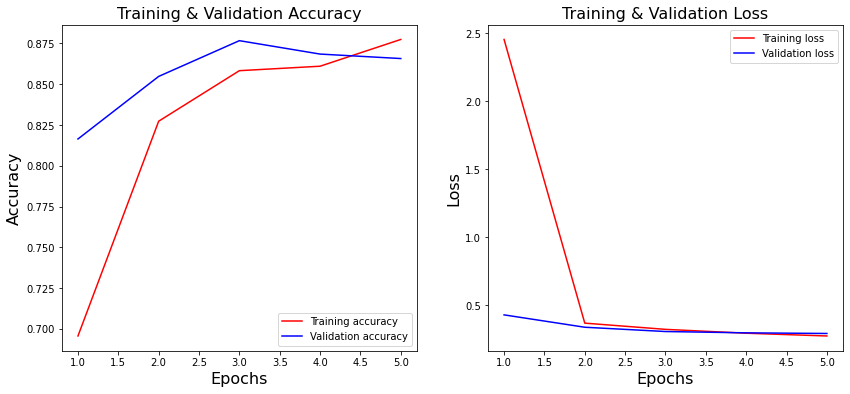

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

20/20 [==============================] - 86s 4s/step
Test accuracy = 89.531250%
Confusion Matrix -> 



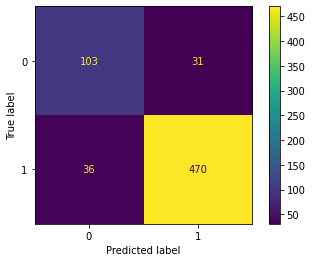

In [ ]:
Y_pred = model.predict(test_gen)

y_pred = Y_pred.argmax(1)
acc = accuracy_score(test_gen.labels.argmax(1), y_pred)
cm = confusion_matrix(test_gen.labels.argmax(1), y_pred)
print(f'Test accuracy = {acc:%}')
print(f'Confusion Matrix -> \n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Training the Handcrafted model with K-Fold Cross Validation

start = time.time()

# Early Stopping callback function
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 2, restore_best_weights = True)
# Garbage Collection callback function
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

nFolds = 7
kfold = KFold(n_splits=nFolds, shuffle=True)

fold = 0
model, acc, history = ([None] * nFolds for i in range(3))
for train, test in kfold.split(inputs, targets):
  model[fold] = handModel()
  model[fold].compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'],
      run_eagerly=True
  )

  print('------------------------------------------------------------------------')
  print(f'Training for fold #{fold + 1} ...')

  history[fold] = model[fold].fit(inputs[train], targets[train],
                                  validation_data = (inputs[test], targets[test]),
                                  epochs = 20, steps_per_epoch=20,
                                  callbacks = [es, ClearMemory()])

  scores = model[fold].evaluate(inputs[test], targets[test], verbose=0)
  acc[fold] = scores[1]
  print(f'Score for fold #{fold + 1}: {model[fold].metrics_names[0]} of {scores[0]}; {model[fold].metrics_names[1]} of {scores[1]:%}')
  fold += 1

# Choosing best model
best = np.argmax(acc)
model = model[best]
acc = acc[best]
history = history[best]
print(f'Best model was at fold #{best + 1} with {acc:%} accuracy')

print(f"Execution took {time.time() - start} seconds")

------------------------------------------------------------------------
Training for fold #1 ...
Epoch 1/20
20/20 [==============================] - 5s 255ms/step - loss: 0.5271 - accuracy: 0.7607 - val_loss: 0.4922 - val_accuracy: 0.7978
Epoch 2/20
20/20 [==============================] - 4s 217ms/step - loss: 0.4851 - accuracy: 0.7899 - val_loss: 0.4796 - val_accuracy: 0.7978
Epoch 3/20
20/20 [==============================] - 4s 212ms/step - loss: 0.4628 - accuracy: 0.7899 - val_loss: 0.4552 - val_accuracy: 0.7978
Score for fold #1: loss of 0.4921935796737671; accuracy of 79.781419%
------------------------------------------------------------------------
Training for fold #2 ...
Epoch 1/20
20/20 [==============================] - 4s 215ms/step - loss: 0.5236 - accuracy: 0.7644 - val_loss: 0.5194 - val_accuracy: 0.7760
Epoch 2/20
20/20 [==============================] - 4s 205ms/step - loss: 0.4797 - accuracy: 0.7935 - val_loss: 0.4890 - val_accuracy: 0.7760
Epoch 3/20
20/20 [======

In [ ]:
# Store model on drive
# pickle.dump(model, open("/content/gdrive/MyDrive/retinaldata/picklehandmodel.sav", 'wb'))
model.save("/content/gdrive/MyDrive/retinaldata/hand/")

In [ ]:
# Load model from drive
# loaded_model = pickle.load(open("/content/gdrive/MyDrive/retinaldata/picklehandmodel.sav", 'rb'))
# model = models.load_model("/content/gdrive/MyDrive/retinaldata/NoSampling/hand/")

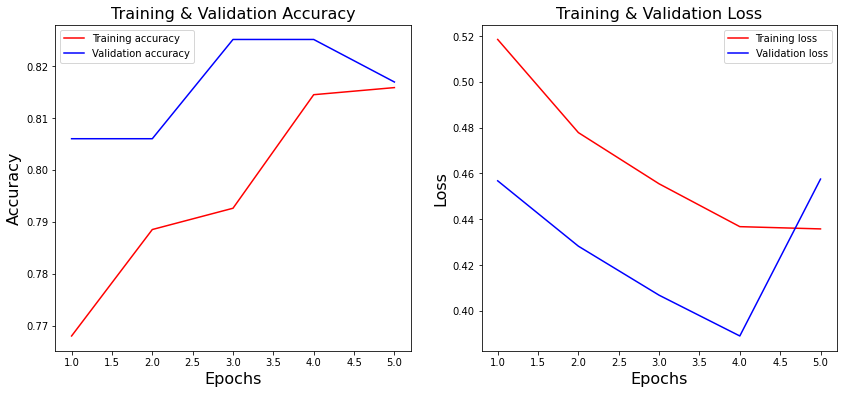

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

20/20 [==============================] - 83s 4s/step
Test accuracy = 0.8265625
Confusion Matrix -> 



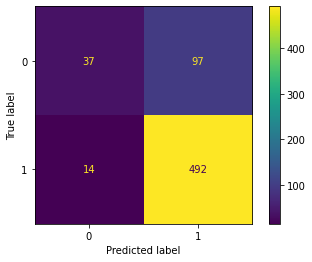

In [ ]:
Y_pred = model.predict(test_gen)

y_pred = Y_pred.argmax(1)
acc = accuracy_score(test_gen.labels.argmax(1), y_pred)
cm = confusion_matrix(test_gen.labels.argmax(1), y_pred)
print(f'Test accuracy = {acc}')
print(f'Confusion Matrix -> \n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()